In [1]:
#NLP project - classement de texte selon toxicité.

#le but de ce premier projet NLP est de se familiariser avec les bases du Traitement automatique
#du langage naturel et de l'analyse de sentiment
#je vais réutiliser les techniques de l'exercise kaggle et des tweets de Trump
#la prédiction se fera en entrainant un classifieur, plusieurs si le premier ne donne pas satisfaction

#cela nous servira de base pour le prochain projet, qui sera plus complexe

In [2]:
#import des librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os

import gensim
import nltk
import sklearn

import re
import string
from string import digits

In [3]:
#chargement des données

toxic_train = pd.read_csv('toxic_comment_classification_train.csv')
toxic_test = pd.read_csv('toxic_comment_classification_test.csv')

In [4]:
#analyse du jeu train
toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
toxic_train.shape

(159571, 8)

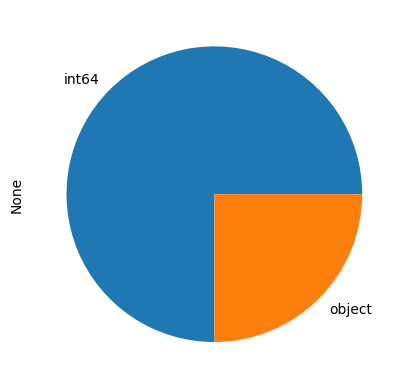

In [6]:
#types de variables
##pourcentage de valeurs en fonction de chaque type d'objets et de valeurs manquantes
toxic_train.dtypes.value_counts().plot.pie();

In [7]:
#nombre et type des variables

toxic_train.dtypes.value_counts()

int64     6
object    2
dtype: int64

In [8]:
#les nuls et les nans 
toxic_train.isnull().sum()
toxic_train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
#le jeu est complet

In [10]:
#traquons les valeurs infinies
# Recherchez les valeurs infinies dans le DataFrame
infinite_values = toxic_train.isin([np.inf, -np.inf]).any()

# Affichez les colonnes contenant des valeurs infinies
print(infinite_values)

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [11]:
#aucune valeur infinie

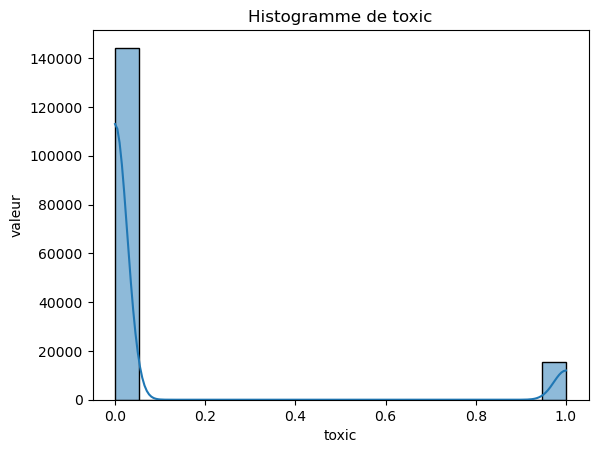

In [12]:
#analyse de la distribution des variables
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(toxic_train["toxic"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de toxic')
plt.xlabel("toxic")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

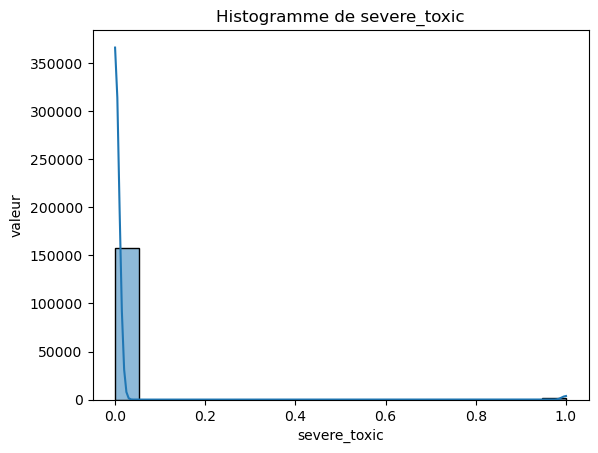

In [13]:
sns.histplot(toxic_train["severe_toxic"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de severe_toxic')
plt.xlabel("severe_toxic")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

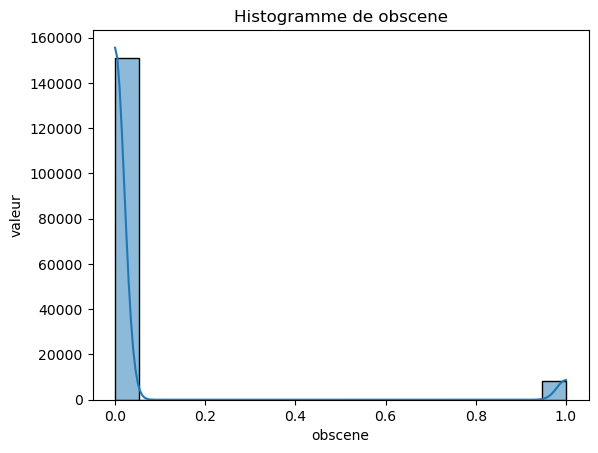

In [14]:
sns.histplot(toxic_train["obscene"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de obscene')
plt.xlabel("obscene")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

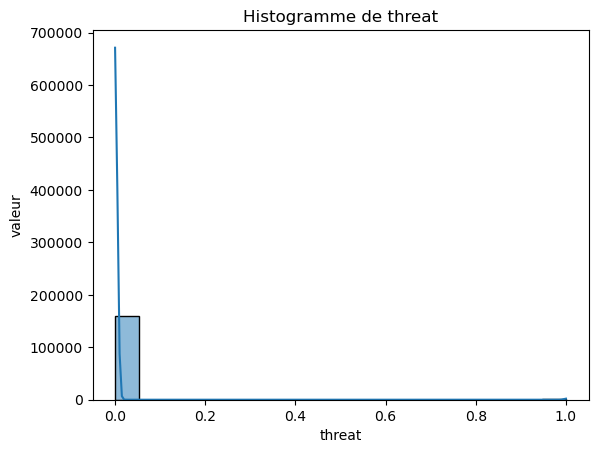

In [15]:
sns.histplot(toxic_train["threat"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de threat')
plt.xlabel("threat")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

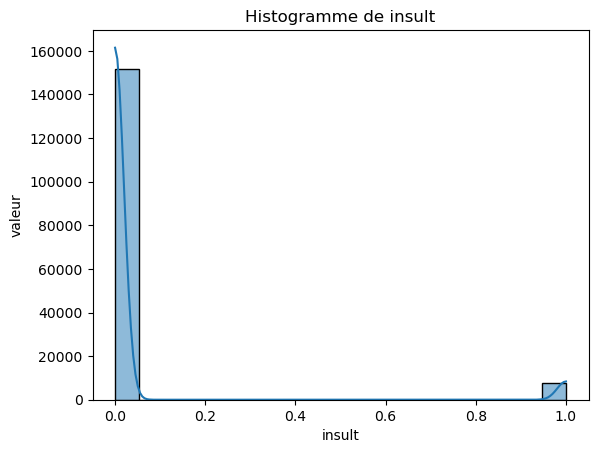

In [16]:
sns.histplot(toxic_train["insult"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de insult')
plt.xlabel("insult")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

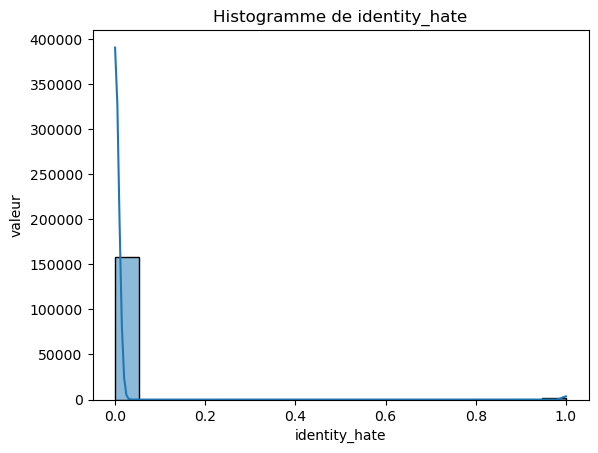

In [17]:
sns.histplot(toxic_train["identity_hate"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de identity_hate')
plt.xlabel("identity_hate")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

In [18]:
#très peu de positifs... il faudra s'attendre à un resampling

In [19]:
#je fais l'hypothèse que le jeu test présente les mêmes caractéritiques que le jeu train, la shape exceptée

In [20]:
# netoyage du jeu de donnée
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'http\S+', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: elem.replace('\n', ' '))
    df[text_field] = df[text_field].apply(lambda elem: elem.replace('_', ' '))
    
    remove_digits = str.maketrans('', '', digits)
    df[text_field] = df[text_field].apply(lambda elem: elem.translate(remove_digits))
    return df

clean_toxic_train = clean_text(toxic_train, 'comment_text')
clean_toxic_test = clean_text(toxic_test, 'comment_text')

In [21]:
clean_toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [22]:
#la collone comment ext a changé. Les 

In [23]:
# Tokenization
#séparons les textes en sac de mots

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

#tokenizer
clean_toxic_train['tokens'] = clean_toxic_train['comment_text'].apply(tokenizer.tokenize)

clean_toxic_test['tokens'] = clean_toxic_test['comment_text'].apply(tokenizer.tokenize)

In [24]:
#vérifions
clean_toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my..."
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour..."
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit..."
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions..."
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re..."


In [25]:
#la liste tokens a été créée, les mots ont bien été individualisés (safuf quelques uns comme daww)

In [26]:
# Explorer les mots et les phrases

all_words = [word for tokens in clean_toxic_train['tokens'] for word in tokens]

sentence_lengths = [len(tokens) for tokens in clean_toxic_train['tokens']]

Vocab = sorted(list(set(all_words)))

print('%s words total, with a vocabulary size of %s' %(len(all_words), len(Vocab)))

10792818 words total, with a vocabulary size of 167844


In [27]:
sentence_lengths

[46,
 16,
 44,
 116,
 14,
 10,
 8,
 21,
 86,
 12,
 501,
 12,
 54,
 147,
 40,
 107,
 11,
 6,
 21,
 84,
 40,
 11,
 80,
 11,
 232,
 22,
 52,
 58,
 28,
 13,
 18,
 13,
 10,
 139,
 56,
 146,
 199,
 51,
 28,
 213,
 37,
 39,
 116,
 8,
 59,
 142,
 14,
 20,
 121,
 200,
 478,
 26,
 33,
 96,
 9,
 19,
 13,
 118,
 339,
 70,
 18,
 55,
 5,
 165,
 33,
 56,
 23,
 30,
 39,
 37,
 32,
 62,
 11,
 189,
 37,
 11,
 44,
 51,
 28,
 13,
 184,
 494,
 96,
 52,
 17,
 23,
 14,
 9,
 61,
 4,
 152,
 72,
 17,
 17,
 90,
 96,
 10,
 23,
 33,
 54,
 17,
 4,
 19,
 76,
 17,
 8,
 154,
 108,
 28,
 23,
 15,
 8,
 109,
 78,
 249,
 11,
 97,
 9,
 48,
 7,
 42,
 52,
 45,
 27,
 20,
 25,
 997,
 33,
 40,
 80,
 44,
 29,
 52,
 37,
 119,
 33,
 18,
 46,
 8,
 9,
 159,
 64,
 334,
 60,
 21,
 119,
 8,
 37,
 88,
 75,
 123,
 102,
 10,
 80,
 18,
 39,
 24,
 53,
 43,
 19,
 587,
 44,
 426,
 18,
 28,
 26,
 120,
 155,
 28,
 68,
 64,
 11,
 79,
 6,
 33,
 6,
 30,
 1,
 19,
 135,
 229,
 11,
 7,
 40,
 23,
 28,
 23,
 18,
 29,
 40,
 51,
 67,
 47,
 16,
 10,
 48,
 

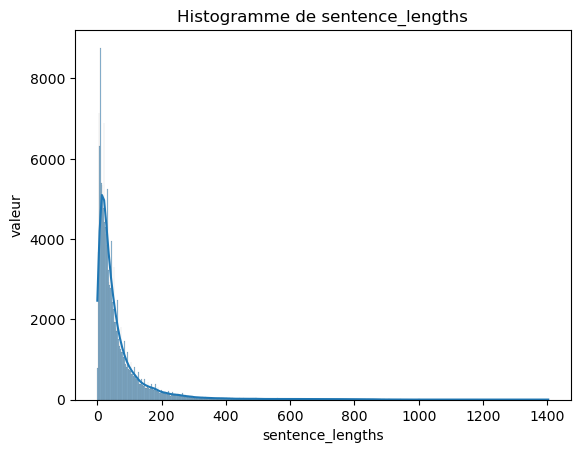

In [28]:
sns.histplot(sentence_lengths, kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de sentence_lengths')
plt.xlabel("sentence_lengths")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

In [29]:
#la plupart des phrases sont très courtes...

In [30]:
from statistics import mean 

mean(sentence_lengths)

67.63646276579078

In [31]:
# Explorer vocab

print(Vocab[0:100])

from collections import Counter

count_all_words = Counter(all_words)
count_all_words.most_common(100)

['a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany', 'aaaaaaaaaah', 'aaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaw', 'aaaaah', 'aaaah', 'aaaannnnyyyywwwwhhhheeeerrrreeee', 'aaaawwww', 'aaaboyz', 'aaages', 'aaaghh', 'aaah', 'aaahhh', 'aaahs', 'aaai', 'aaajade', 'aaan', 'aaand', 'aaarrrgggh', 'aaaww', 'aab', 'aaba', 'aaberg', 'aabove', 'aac', 'aacd', 'aachen', 'aachi', 'aacs', 'aad', 'aadd', 'aademia', 'aadil', 'aadmi', 'aadu', 'aaf', 'aaffect', 'aafia', 'aaflight', 'aafs', 'aagadu', 'aage', 'aagf', 'aagin', 'aah', 'aahahahahahaha', 'aahank', 'aahh', 'aahil', 'aahoa', 'aai', 'aaiha', 'aajacksoniv', 'aajonus', 'aakash', 'aake', 'aalborg', 'aalertbot', 'aalexa', 'aaliya', 'aaliyah', 'aals', 'aalst', 'aam', 'aami', 'aamir', 'aamirjamil', 'aaml', 'aamu', 'aan', 'aanas', 'aand', 'aandahl', 'aang', 'aao', 'aaot', 'aap', 'aapl', 'aapropriate', 'aar', 'aara

[('the', 496731),
 ('to', 297377),
 ('i', 240441),
 ('of', 224682),
 ('and', 224103),
 ('you', 218316),
 ('a', 216739),
 ('is', 176414),
 ('that', 160870),
 ('it', 148610),
 ('in', 145376),
 ('for', 102835),
 ('this', 97664),
 ('not', 93783),
 ('on', 89919),
 ('be', 83473),
 ('as', 77436),
 ('s', 73839),
 ('have', 72240),
 ('are', 72021),
 ('your', 63400),
 ('t', 61160),
 ('with', 59589),
 ('if', 58647),
 ('article', 57534),
 ('was', 54582),
 ('or', 53425),
 ('but', 51106),
 ('page', 46421),
 ('wikipedia', 46158),
 ('my', 45629),
 ('an', 44973),
 ('from', 41499),
 ('by', 41407),
 ('do', 40080),
 ('can', 39545),
 ('at', 39536),
 ('me', 37305),
 ('talk', 37255),
 ('about', 37132),
 ('so', 36605),
 ('what', 35630),
 ('there', 35278),
 ('all', 31646),
 ('has', 30727),
 ('will', 30470),
 ('please', 29799),
 ('no', 29331),
 ('would', 29322),
 ('they', 29317),
 ('he', 29194),
 ('one', 29183),
 ('like', 28005),
 ('just', 27826),
 ('we', 25430),
 ('which', 25368),
 ('any', 25148),
 ('been', 249

In [32]:
#les données sont exploitables, passons à la prédiction

In [33]:
#création du jeu train et test

#nous nous pencherons sur la prédiction de Toxic : ce sont les plus courants

from sklearn.model_selection import train_test_split

list_corpus = clean_toxic_train['comment_text']
list_labels = clean_toxic_train['toxic']
#, 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train, X_val, y_train, y_val = train_test_split(list_corpus, list_labels, test_size = 0.2,
                                                   random_state = 0)

In [34]:
#Embedding
# TFIDF bag of words

#TF-IDF est une méthode couramment utilisée pour transformer des documents textuels en vecteurs numériques,
# ce qui les rend adaptés à une utilisation dans des algorithmes de classification, d'apprentissage automatique, etc.

#import librairie
from sklearn.feature_extraction.text import TfidfVectorizer

#Création d'une instance de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w+')

#ci, un objet tfidf_vectorizer est créé en spécifiant qu'il doit analyser le texte mot par mot (analyzer='word')
# et utiliser le modèle de tokenisation basé sur l'expression régulière \w+, 
# qui correspond à des mots composés de caractères alphanumériques.


tfidf = dict()
#tfidf['train'] = (tfidf_vectorizer.fit_transform(X_train), y_train)
#tfidf['val'] = (tfidf_vectorizer.transform(X_val), y_val)

#print(tfidf['train'][0].shape)
#print(tfidf['val'][0].shape)

#Calcul de TF-IDF pour les données d'entraînement et de test :
tfidf['all_train'] = (tfidf_vectorizer.fit_transform(clean_toxic_train['comment_text']))
tfidf['test'] = (tfidf_vectorizer.transform(clean_toxic_test['comment_text']))

#Affichage des dimensions des vecteurs TF-IDF :
print(tfidf['all_train'].shape)
print(tfidf['test'].shape)



(159571, 167844)
(153164, 167844)


In [35]:
#classifier

#régréssion logisitique, non optimisée
#par contre, je vais augmenter le nbr d'itérations afin d'obtenir la convergence du modèle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


submission = pd.DataFrame.from_dict({'id': clean_toxic_test['id']})
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']



for label_name in label_names:
    train_target = clean_toxic_train[label_name]
    classifier = LogisticRegression(max_iter=1000)
    
    # Entraîner le modèle sur les données d'entraînement pour cette catégorie
    classifier.fit(tfidf['all_train'], train_target)
    
    # Transformer les commentaires textuels de test en vecteurs TF-IDF
    test_tfidf = tfidf_vectorizer.transform(clean_toxic_test['comment_text'])
    
    # Faire les prédictions de probabilité pour la catégorie actuelle
    submission[label_name] = classifier.predict_proba(test_tfidf)[:, 1]
    
    


In [36]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997656,0.160446,0.992676,0.039268,0.948664,0.246046
1,0000247867823ef7,0.005524,0.001417,0.003198,0.000408,0.004757,0.002928
2,00013b17ad220c46,0.039229,0.005780,0.017945,0.001700,0.020527,0.005714
3,00017563c3f7919a,0.003160,0.001602,0.003255,0.001381,0.003705,0.000845
4,00017695ad8997eb,0.035106,0.003620,0.011085,0.002165,0.010488,0.002975
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.700106,0.003989,0.181857,0.001491,0.055202,0.006619
153160,fffd7a9a6eb32c16,0.049825,0.003342,0.021864,0.002310,0.017467,0.010186
153161,fffda9e8d6fafa9e,0.006516,0.001374,0.006520,0.000678,0.004867,0.001664
153162,fffe8f1340a79fc2,0.023488,0.001419,0.011333,0.000738,0.012010,0.008966


In [37]:
#Les performances me semblet satisfaisantes. Je pense que je vais m'arreter là pour ce petit projet.

In [38]:
#enregister le résultat sous forme de csv
submission.to_csv('submission.csv', index = False)

In [39]:
toxic_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my..."
